# Preparação do ambiente

## Bibliotecas

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string

from os import path as osp
from pprint import pprint
from tabulate import tabulate

## Constantes e funções auxiliares

In [2]:
NULL_STRING = '#NULLO#'
FILE_ANUNCIOS = '../datasets/anuncios.parquet'
FILE_ANUNCIOS_AMOSTRA = '../datasets/anuncios_amostra.parquet'

In [3]:
def flatten_matrix(matrix):
    return [item for row in matrix for item in row]

In [4]:
def extract_amazon_images(row):
    imagens = []
    imagens.append(row['Imagem'].split()[0])
    imagens.extend(row['Imagens'].split())

    imagens = [imagem for imagem in imagens if imagem.startswith('http')]
    if len(imagens) >= 3:
        imagens = imagens[:3]
    elif len(imagens) == 2:
        imagens.extend([''])
    elif len(imagens) == 1:
        imagens.extend(['',''])
    else:
        imagens.extend(['','',''])

    return pd.Series(imagens)

def extract_amazon_desc(row):
    desc = '\n'.join(row)
    desc = desc.replace(NULL_STRING,' ')
    desc = re.sub('\s+', ' ', desc)
    return desc

In [5]:
def extract_magalu_images(row):
    imagens = []
    imagens.append(row['Imagem'].split()[0])
    imagens.extend(row['Imagens'].split(','))

    imagens = [imagem for imagem in imagens if imagem.startswith('http')]
    if len(imagens) >= 3:
        imagens = imagens[:3]
    elif len(imagens) == 2:
        imagens.extend([''])
    elif len(imagens) == 1:
        imagens.extend(['',''])
    else:
        imagens.extend(['','',''])

    return pd.Series(imagens)

In [6]:
def format_issue(row,remove_punct=False):
    nome,desc,img0,img1,img2 = row
    
    # remove null string
    desc = desc.replace(NULL_STRING,'')
    # remove punctiation from nome and desc
    if remove_punct:
        nome = nome.translate(str.maketrans('', '', string.punctuation))
        desc = desc.translate(str.maketrans('', '', string.punctuation))

    # remove ponto-e-vírgula e aspas duplas para evitar a 
    # identificação incorreta de campos ao importar para o redmine
    desc = desc.replace(';',',')
    desc = desc.replace('"',"''")
    # remove multiple linebrakes and spaces
    desc = re.sub('\n+','\n\n',desc)
    desc = re.sub('\s+',' ',desc)
    desc = desc.strip()
    
    img_css = '{max-width:250px; height:auto}'
    if len(img2) > 0:
        img_list = f'!{img_css}{img0}! !{img_css}{img1}! !{img_css}{img2}!'
    elif len(img1) > 0:
        img_list = f'!{img_css}{img0}! !{img_css}{img1}!'
    elif len(img0) > 0:
        img_list = f'!{img_css}{img0}!'
    else:
        img_list = ''
        
    if len(desc) >= 1:
        issue = f'h1. {nome}\n\n{desc}\n\n{img_list}'
    else:
        issue = f'h1. {nome}\n\n{img_list}'
    
    return issue.strip()

In [7]:
def plot_donut(labels,values,title,startangle=30):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    
    ax.set_title(title)
    plt.show()

# Carga e prepação dos dados

## Dados pré processados

In [8]:
if osp.exists(FILE_ANUNCIOS):
    df_anuncios = pd.read_parquet(FILE_ANUNCIOS)
    df_anuncios.head(5)

## Dados brutos

### Amazon

In [9]:
file_amazon_reindexed = '../datasets/amazon_reindexed.parquet'
df_amazon = pd.read_parquet(file_amazon_reindexed)

df_amazon = df_amazon.drop_duplicates(subset='Nome')

columns_to_keep = ['Link', 'Nome', 'Descrição', 'Descrição_Principal', 'Imagem', 'Imagens' ]
df_amazon = df_amazon[columns_to_keep]

df_amazon['marketplace'] = 'amazon'

df_amazon['desc'] = df_amazon[['Descrição', 'Descrição_Principal']].apply(lambda row: extract_amazon_desc(row),axis=1)
# df_amazon['img_list'] = df_amazon[['Imagem', 'Imagens']].apply(lambda row: extract_amazon_images(row),axis=1)
df_amazon[['img0','img1','img2']] = df_amazon[['Imagem', 'Imagens']].apply(lambda row: extract_amazon_images(row),axis=1)

columns_to_keep = ['marketplace', 'Link', 'Nome', 'desc', 'img0','img1','img2']
df_amazon = df_amazon[columns_to_keep]
df_amazon.columns = ['marketplace', 'link', 'nome', 'desc', 'img0', 'img1', 'img2']

df_amazon.head()

,marketplace,link,nome,desc,img0,img1,img2
0,amazon,https://www.amazon.com.br/Especiais-Cinematic-...,Filtro de Lente de Efeitos Especiais Blue Stre...,Especificações: Modelo aplicável: este filtro ...,https://m.media-amazon.com/images/I/61ZdffRDj2...,https://m.media-amazon.com/images/I/51DeP4IE2F...,https://m.media-amazon.com/images/I/41w7kz5r4P...
1,amazon,https://www.amazon.com.br/Motores-Escova-Conju...,"Motores Sem Escova, 4 Conjuntos de Motores Sem...",1. Modelo de uso: Este motor sem escova de dro...,https://m.media-amazon.com/images/I/51aZmDncic...,https://m.media-amazon.com/images/I/31mER3G37I...,https://m.media-amazon.com/images/I/31jk4g-fUt...
2,amazon,https://www.amazon.com.br/Armazenamento-Protet...,"Bolsa de Armazenamento Protetora para Drone, C...",1. Excelente proteção: o case rígido do drone ...,https://m.media-amazon.com/images/I/612uWGXrp7...,https://m.media-amazon.com/images/I/41JfSjIxxR...,https://m.media-amazon.com/images/I/41CVth1dqO...
3,amazon,https://www.amazon.com.br/EQUSS-V-strom-Motoci...,EQUSS Para DUCATI DL650 DL1000 V-strom DL 650 ...,1. Material: liga de alumínio [Super Grip] - D...,https://m.media-amazon.com/images/I/51-m8iNiuL...,https://m.media-amazon.com/images/I/31VLMQCsxU...,https://m.media-amazon.com/images/I/31WjqM+BqB...
4,amazon,https://www.amazon.com.br/remote-control-brush...,"remote control car brushless motor servo kit,r...",,https://m.media-amazon.com/images/I/61Hzfl2r75...,https://m.media-amazon.com/images/I/41P1kyyx1l...,https://m.media-amazon.com/images/I/41I9plec-T...


### Magalu

In [10]:
file_magalu_reindexed = '../datasets/magalu_redindexed.parquet.gzip'
df_magalu = pd.read_parquet(file_magalu_reindexed)

df_magalu = df_magalu.drop_duplicates(subset='Nome')

columns_to_keep = ['Link', 'Nome', 'Descrição', 'Imagem', 'Imagens' ]
df_magalu = df_magalu[columns_to_keep]

df_magalu['marketplace'] = 'magalu'

df_magalu[['img0','img1','img2']] = df_magalu[['Imagem', 'Imagens']].apply(lambda row: extract_magalu_images(row),axis=1)
columns_to_keep = ['marketplace', 'Link', 'Nome', 'Descrição', 'img0','img1','img2']
df_magalu = df_magalu[columns_to_keep]
df_magalu.columns = ['marketplace', 'link', 'nome', 'desc', 'img0', 'img1', 'img2']

df_magalu.head()

,marketplace,link,nome,desc,img0,img1,img2
0,magalu,https://validate.perfdrive.com/ca4df1c7abf7ea2...,Pedimos desculpas pela inconveniência...,#NULLO#,https://a-static.mlcdn.com.br/280x210/forever-...,,
18808,magalu,https://www.magazineluiza.com.br/02-forever-li...,02 Forever Liss Máscara Btx Zero Hidratante Se...,Forever Liss - Btx Zero 250gAge eliminando o f...,https://a-static.mlcdn.com.br/280x210/02-forev...,https://a-static.mlcdn.com.br/90x90/02-forever...,https://a-static.mlcdn.com.br/90x90/02-forever...
18809,magalu,https://www.magazineluiza.com.br/02-unidades-d...,02 Unidades do Carregador Portátil KAIDI KD-95...,O presente produto é uma fonte de alimentação ...,https://a-static.mlcdn.com.br/280x210/02-unida...,https://a-static.mlcdn.com.br/90x90/02-unidade...,https://a-static.mlcdn.com.br/90x90/02-unidade...
18810,magalu,https://www.magazineluiza.com.br/03-forever-li...,03 Forever Liss Máscara Btx Zero Hidratante Se...,Forever Liss - Btx Zero 250gAge eliminando o f...,https://a-static.mlcdn.com.br/280x210/03-forev...,https://a-static.mlcdn.com.br/90x90/03-forever...,https://a-static.mlcdn.com.br/90x90/03-forever...
18811,magalu,https://www.magazineluiza.com.br/03-lampada-lu...,03 Lâmpada Luminária Toque 3 Led Armário Pared...,KIT 03 LAMPADAS DE TOQUE LED LUMINÁRIA DECORAÇ...,https://a-static.mlcdn.com.br/90x90/03-lampada...,https://a-static.mlcdn.com.br/90x90/03-lampada...,https://a-static.mlcdn.com.br/90x90/03-lampada...


### Mercado Livre

In [11]:
file_ml_reindexed = '../datasets/ml_redindexed.parquet.gzip'
df_ml = pd.read_parquet(file_ml_reindexed)

df_ml = df_ml.drop_duplicates(subset='Nome')

columns_to_keep = ['Link', 'Nome', 'Descrição', 'Imagem', 'Imagens' ]
df_ml = df_ml[columns_to_keep]

df_ml['marketplace'] = 'mercadolivre'

df_ml[['img0','img1','img2']] = df_ml[['Imagem', 'Imagens']].apply(lambda row: extract_magalu_images(row),axis=1)
columns_to_keep = ['marketplace', 'Link', 'Nome', 'Descrição', 'img0','img1','img2']
df_ml = df_ml[columns_to_keep]
df_ml.columns = ['marketplace', 'link', 'nome', 'desc', 'img0', 'img1', 'img2']

df_ml

,marketplace,link,nome,desc,img0,img1,img2
0,mercadolivre,https://informatica.mercadolivre.com.br/acesso...,Conector De Botão De Joystick Jamma Arcade Cab...,#NULLO#,,,
1,mercadolivre,https://lista.mercadolivre.com.br/acessorios-p...,Dispositivo De Kit De Microfone Auxiliar Com T...,#NULLO#,,,
2,mercadolivre,https://lista.mercadolivre.com.br/acessorios-v...,Bolsa Bloqueadora De Sinais De Chave De Carro ...,#NULLO#,,,
3,mercadolivre,https://lista.mercadolivre.com.br/acessorios-v...,Par De Intercomunicador De Capacete V6 Pro Eje...,#NULLO#,,,
4,mercadolivre,https://lista.mercadolivre.com.br/acessorios-v...,Bolsa Faraday Bolsa Jammer Com Bloqueio De Sin...,#NULLO#,,,
...,...,...,...,...,...,...,...
76165,mercadolivre,https://www.mercadolivre.com.br/xiaomi-smart-m...,"Xiaomi Smart Mi Band 8 Tela 1.62"" Amoled Caixa...",XIAOMI Smart Band 8 Versão Global Lançamento d...,https://http2.mlstatic.com/D_NQ_NP_879773-MLU7...,,
76166,mercadolivre,https://www.mercadolivre.com.br/xiaomi-stick-4...,Xiaomi Stick 4k MDZ-27-AA controle de voz 4K 8...,Com o media player da Xiaomi você vai ser capa...,https://http2.mlstatic.com/D_NQ_NP_679763-MLU7...,,
76168,mercadolivre,https://www.mercadolivre.com.br/xiaomi-stick-4...,Xiaomi Stick 4k MDZ-27-AA de voz 4K 8GB preto ...,Com o media player da Xiaomi você vai ser capa...,https://http2.mlstatic.com/D_NQ_NP_679763-MLU7...,,
76170,mercadolivre,https://www.mercadolivre.com.br/y68-d20-smart-...,Y68 D20 Smart Watch Bluetooth Fitness Sports P...,"Tecnologia, qualidade e sofisticação definem o...",https://http2.mlstatic.com/D_NQ_NP_696771-MLA4...,,


### União dos dados em único dataframe

In [12]:
df_anuncios = pd.concat([df_amazon, df_magalu, df_ml])
df_anuncios = df_anuncios.reset_index(drop=True)
df_anuncios.to_parquet(FILE_ANUNCIOS)
df_anuncios.head(5)

,marketplace,link,nome,desc,img0,img1,img2
0,amazon,https://www.amazon.com.br/Especiais-Cinematic-...,Filtro de Lente de Efeitos Especiais Blue Stre...,Especificações: Modelo aplicável: este filtro ...,https://m.media-amazon.com/images/I/61ZdffRDj2...,https://m.media-amazon.com/images/I/51DeP4IE2F...,https://m.media-amazon.com/images/I/41w7kz5r4P...
1,amazon,https://www.amazon.com.br/Motores-Escova-Conju...,"Motores Sem Escova, 4 Conjuntos de Motores Sem...",1. Modelo de uso: Este motor sem escova de dro...,https://m.media-amazon.com/images/I/51aZmDncic...,https://m.media-amazon.com/images/I/31mER3G37I...,https://m.media-amazon.com/images/I/31jk4g-fUt...
2,amazon,https://www.amazon.com.br/Armazenamento-Protet...,"Bolsa de Armazenamento Protetora para Drone, C...",1. Excelente proteção: o case rígido do drone ...,https://m.media-amazon.com/images/I/612uWGXrp7...,https://m.media-amazon.com/images/I/41JfSjIxxR...,https://m.media-amazon.com/images/I/41CVth1dqO...
3,amazon,https://www.amazon.com.br/EQUSS-V-strom-Motoci...,EQUSS Para DUCATI DL650 DL1000 V-strom DL 650 ...,1. Material: liga de alumínio [Super Grip] - D...,https://m.media-amazon.com/images/I/51-m8iNiuL...,https://m.media-amazon.com/images/I/31VLMQCsxU...,https://m.media-amazon.com/images/I/31WjqM+BqB...
4,amazon,https://www.amazon.com.br/remote-control-brush...,"remote control car brushless motor servo kit,r...",,https://m.media-amazon.com/images/I/61Hzfl2r75...,https://m.media-amazon.com/images/I/41P1kyyx1l...,https://m.media-amazon.com/images/I/41I9plec-T...


╭───────────────┬──────────────╮
│ Marketplace   │   Quantidade │
├───────────────┼──────────────┤
│ amazon        │       143657 │
├───────────────┼──────────────┤
│ mercadolivre  │        54862 │
├───────────────┼──────────────┤
│ magalu        │        31647 │
╰───────────────┴──────────────╯


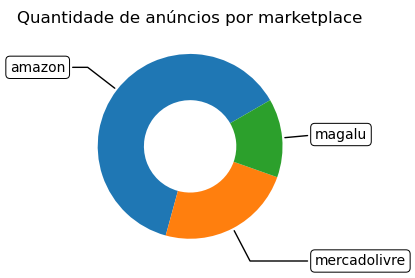

In [13]:
qt_anuncios = df_anuncios['marketplace'].value_counts()
labels, values = qt_anuncios.index, qt_anuncios.values

print(tabulate({'Marketplace': list(qt_anuncios.index), 'Quantidade': list(qt_anuncios.values)},headers="keys",intfmt=',',tablefmt='rounded_grid').replace(',','.'))
plot_donut(labels,values, 'Quantidade de anúncios por marketplace',startangle=30)

# Selecionar e preparar amostra

## Selecionar amostra

In [14]:
n_samples = 20000
df_samples_to_label = df_anuncios.iloc[:,:].sample(n_samples,random_state=111)
df_samples_to_label.head()

,marketplace,link,nome,desc,img0,img1,img2
181789,mercadolivre,https://produto.mercadolivre.com.br/MLB-205059...,Suporte Adaptador Alto Falantes Celta Prisma D...,Aro Suporte Adaptador de Falantes Novo Celta P...,https://http2.mlstatic.com/D_NQ_NP_917365-MLB3...,,
201982,mercadolivre,https://produto.mercadolivre.com.br/MLB-342462...,Combo 2 Câmeras Segurança Ip Wifi 360 Hd Infra...,#NULLO#,https://http2.mlstatic.com/D_NQ_NP_821207-MLB7...,,
10179,amazon,https://www.amazon.com.br/YONGYAO-Bluetooth-Tr...,YONGYAO Bluetooth 5.0 + EDR Áudio Transmissor ...,Parâmetros do produto: Versão Bluetooth: 5.0 ...,https://m.media-amazon.com/images/I/31w1qZXJu-...,https://m.media-amazon.com/images/I/31w1qZXJu-...,https://m.media-amazon.com/images/I/31d0XtNGZh...
198797,mercadolivre,https://produto.mercadolivre.com.br/MLB-336152...,Drone Hk9 Câmera 4k Uhd Vídeo Profissional 2.4...,Drone HK9 Zangão Câmera 4k Uhd Vídeo 2.4ghz Pr...,https://http2.mlstatic.com/D_NQ_NP_787531-MLB7...,https://http2.mlstatic.com/D_NQ_NP_744408-MLB7...,https://http2.mlstatic.com/D_NQ_NP_748519-MLB7...
116277,amazon,https://www.amazon.com.br/Microfone-Transmisso...,Tempaky 1 Par Microfone Sem Fio Sistema Micfon...,,,,


╭───────────────┬──────────────╮
│ Marketplace   │   Quantidade │
├───────────────┼──────────────┤
│ amazon        │        12516 │
├───────────────┼──────────────┤
│ mercadolivre  │         4731 │
├───────────────┼──────────────┤
│ magalu        │         2753 │
╰───────────────┴──────────────╯


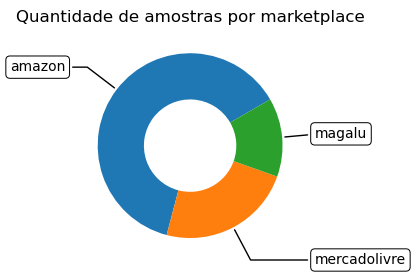

In [15]:
qt_samples = df_samples_to_label['marketplace'].value_counts()
labels, values = qt_samples.index, qt_samples.values

print(tabulate({'Marketplace': list(qt_samples.index), 'Quantidade': list(qt_samples.values)},headers="keys",intfmt=',',tablefmt='rounded_grid').replace(',','.'))
plot_donut(labels,values, 'Quantidade de amostras por marketplace',startangle=30)

## Exportar para LabelStudio

Após testes com o LabelStudio e Fiscaliza (Redmine), optamos for fazer a rotulagem no Fiscaliza. Assim, essa parte do código foi comentada para eventual uso futuro.

In [ ]:
# df_label_studio = df_samples_to_label.copy()
# df_label_studio.head(5)

In [ ]:
# # Lista de imagens para baixar
# images = []
# images.extend(df_label_studio['img0'].to_list())
# images.extend(df_label_studio['img1'].to_list())
# images.extend(df_label_studio['img2'].to_list())
# images = [f'wget {image}\n' for image in images if len(image)>0]
# with open('images_to_download.sh','w') as f:
#     f.writelines(images)
# images[:5]

In [ ]:
# # ajustar caminho das imagens (local storage)
# for col in ['img0', 'img1', 'img2']:
#     df_label_studio[col] = df_label_studio[col].apply(lambda x: f'/data/local-files/?d=images/{x.split("/")[-1]}' if len(x) > 0 else '/data/local-files/?d=images/none.jpg')
# df_label_studio.head()

In [ ]:
# if 'sample_id' not in df_label_studio.columns:
#     print('Create sample_id column')
#     df_label_studio = df_label_studio.reset_index()
#     new_columns = ['sample_id', 'nome', 'desc', 'img0', 'img1', 'img2']
#     df_label_studio.columns = new_columns
# df_label_studio.head()

In [ ]:
# samples = df_label_studio.to_dict('records')
# samples[0]
# with open('../datasets/samples_to_label_studio.json','w') as f:
#     json.dump(samples,f)
# pprint(samples[0])

## Exportar para fiscaliza

In [16]:
# título da última tarefa no Fiscaliza
# as novas terão numeração sequencial a partir desta
fiscaliza_last_issue = 90000100
format_title = lambda i: f'LABEL_PACP_2024_{str(i+1+fiscaliza_last_issue).zfill(8)}'

df_fiscaliza = df_samples_to_label.copy()

# neste momento selecionar uma pequena amostra para o teste piloto
# após o piloto, comentar as duas linhas a seguir para gerar amostras
# para criar as tarefas de rotulagem em produção
fiscaliza_sample_size = 500
df_fiscaliza = df_fiscaliza.sample(fiscaliza_sample_size,random_state=1653)

df_fiscaliza = df_fiscaliza.reset_index(drop=True)

columns_to_issue = ['nome', 'desc', 'img0', 'img1', 'img2']

df_fiscaliza['Título'] = df_fiscaliza.index.map(format_title)
df_fiscaliza['Descrição'] = df_fiscaliza[columns_to_issue].apply(lambda row: format_issue(row),axis=1)

df_fiscaliza['Tipo'] = 'Rotulagem de Dados'
df_fiscaliza['Situação'] = 'Responder pesquisa'

df_fiscaliza['Data de início'] = '15/04/2024'
df_fiscaliza['Data limite'] = '31/05/2024'

# relacionar os fiscais para atribuição das tarefas de rotulagems
# as tarefas serão distribuídas igualmente aos fiscais relacionados
fiscais = ['maxwelfreitas', 
           'costalo',
           'josias',
           'romildo',
           'williams',
           'maxwelfreitas', 
           'joaotavares', 
           'peluchi', 
           'licindo', 
           'redinz']

# quantidade de tarefas (linhas) para cada fiscal
n = len(fiscais)
n_chuncks = round(len(df_fiscaliza)/n)

# atribuir as tarefas a cada fiscal
list_chuncks = [df_fiscaliza[i:i+n_chuncks].index for i in range(0,len(df_fiscaliza),n_chuncks)]
for i,chunck in enumerate(list_chuncks):
    df_fiscaliza.loc[chunck,'Atribuído para'] = fiscais[i]

columns_to_issues = ['Tipo', 'Situação', 'Título', 'Descrição', 'Data de início', 'Data limite', 'Atribuído para']

file_samples_fiscaliza = '../datasets/samples_to_fiscaliza.csv'
file_samples_fiscaliza_issues = '../datasets/samples_to_fiscaliza_issues.csv'

df_fiscaliza.to_csv(file_samples_fiscaliza,index=False,sep=';')
df_fiscaliza[columns_to_issues].to_csv(file_samples_fiscaliza_issues,index=False,sep=';')

df_fiscaliza

,marketplace,link,nome,desc,img0,img1,img2,Título,Descrição,Tipo,Situação,Data de início,Data limite,Atribuído para
0,amazon,https://www.amazon.com.br/infravermelho-univer...,Smart WiFi IR Remote Control Hub de controle r...,Controle de voz mãos-livres e IFTTT - Use com...,https://m.media-amazon.com/images/I/51e27RuCLK...,https://m.media-amazon.com/images/I/41lnGjR3j+...,https://m.media-amazon.com/images/I/41CI3w4HuY...,LABEL_PACP_2024_90000101,h1. Smart WiFi IR Remote Control Hub de contro...,Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,maxwelfreitas
1,mercadolivre,https://produto.mercadolivre.com.br/MLB-220423...,Sensor Indicacao Pressao Pneus Cruze 2017 2018...,SENSOR DE PRESSÃO DO PNEU TPMS ( GM )\nFREQUE...,https://http2.mlstatic.com/D_NQ_NP_876686-MLB4...,,,LABEL_PACP_2024_90000102,h1. Sensor Indicacao Pressao Pneus Cruze 2017 ...,Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,maxwelfreitas
2,magalu,https://www.magazineluiza.com.br/capa-de-celul...,Capa De Celular Feminina Samsung A22 Cd 274 - ...,Descrição As capinhas para celular personaliza...,https://a-static.mlcdn.com.br/280x210/capa-de-...,https://a-static.mlcdn.com.br/90x90/capa-de-ce...,,LABEL_PACP_2024_90000103,h1. Capa De Celular Feminina Samsung A22 Cd 27...,Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,maxwelfreitas
3,amazon,https://www.amazon.com.br/Bracket-Compatible-R...,"Vision Bracket Upper Cover, Drone Vision Senso...",,https://m.media-amazon.com/images/I/41N+SIPu4R...,https://m.media-amazon.com/images/I/411Icrihfs...,https://m.media-amazon.com/images/I/31LKUbQyZf...,LABEL_PACP_2024_90000104,"h1. Vision Bracket Upper Cover, Drone Vision S...",Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,maxwelfreitas
4,mercadolivre,https://www.mercadolivre.com.br/camera-de-segu...,Camera De Segurança Wyze Cam V3 Noturna Hd Int...,Você não precisará mais se preocupar com a vig...,https://http2.mlstatic.com/D_NQ_NP_636076-MLB5...,https://http2.mlstatic.com/D_NQ_NP_722493-MLB5...,,LABEL_PACP_2024_90000105,h1. Camera De Segurança Wyze Cam V3 Noturna Hd...,Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,maxwelfreitas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,amazon,https://www.amazon.com.br/YONGYAO-Suporte-carr...,YONGYAO Suporte de carregamento rápido sem fio...,,https://m.media-amazon.com/images/I/3148QlXq9B...,,,LABEL_PACP_2024_90000596,h1. YONGYAO Suporte de carregamento rápido sem...,Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,redinz
496,amazon,https://www.amazon.com.br/Smartphone-Nokia-Tri...,Smartphone Nokia G60 5G 128GB + 6GB RAM Tela 6...,,,,,LABEL_PACP_2024_90000597,h1. Smartphone Nokia G60 5G 128GB + 6GB RAM Te...,Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,redinz
497,mercadolivre,https://produto.mercadolivre.com.br/MLB-346045...,Mochila Pra Faculdade Espaçosa E De Boa Qualid...,#NULLO#,https://http2.mlstatic.com/D_NQ_NP_664739-MLB7...,,,LABEL_PACP_2024_90000598,h1. Mochila Pra Faculdade Espaçosa E De Boa Qu...,Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,redinz
498,amazon,https://www.amazon.com.br/Transmissor-Adaptado...,"Transmissor Adaptador de áudio, Adaptador de á...","1. PROJETO PROFISSIONAL: Aparência elegante, p...",https://m.media-amazon.com/images/I/51aKvyJmAv...,https://m.media-amazon.com/images/I/315lZehkT7...,https://m.media-amazon.com/images/I/315lZehkT7...,LABEL_PACP_2024_90000599,"h1. Transmissor Adaptador de áudio, Adaptador ...",Rotulagem de Dados,Responder pesquisa,15/04/2024,31/05/2024,redinz
